In [110]:
# Import all the libraries
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.
pd.set_option('display.max_columns', None)
import glob
import datetime
import os
import json
from io import StringIO
import matplotlib.pyplot as plt
%matplotlib inline

For this exploratory analysis we used the cluster to randomly sample the data and retrieve the metadata for the items that appear in our review sample.

In [111]:
# Paths to the data and metadata folders.
DATA_FOLDER = 'data/'
META_FOLDER = DATA_FOLDER + 'meta/'

In [112]:
# Load one data file
def load_one_file(path):
    with open(path) as f:
        return [json.loads(line) for line in f]

# Load one metadata file. The rows aren't proper JSON
# but they can be parsed using python's eval function
# as per the dataset's web page.
def load_one_meta_file(path):
    with open(path) as f:
        return [eval(line) for line in f]

# The sample we extracted is still too large, so we'll only use the first 100 files
data_files = glob.glob(DATA_FOLDER + 'part-000*')
data = sum(map(load_one_file, data_files), [])

# The meta folder contains metadata for all the items we were interested in.
meta_files = glob.glob(META_FOLDER + '*')
meta = sum(map(load_one_meta_file, meta_files), [])

# Create the two dataframes
df = pd.DataFrame(data)
meta_df = pd.DataFrame(meta)

In [113]:
# Join the dataframes. Since our analysis relies on the metadata for a good part
# we have to remove any reviews for which metadata is not available.
joined = pd.merge(df, meta_df, how='inner')

# Parse the review time as a DateTime and add a review month column
joined['reviewTime'] = pd.to_datetime(joined.unixReviewTime, unit='s')
joined['reviewMonth'] = joined.reviewTime.map(lambda t: t.month)
#jc
joined['reviewYear'] = joined.reviewTime.map(lambda t: t.year)

In [114]:
# Similarly we don't want any reviews for which the price is either NaN or 0
# or for which the category is NaN
joined = joined.dropna(axis=0, subset=['categories', 'price'])
joined = joined[joined.price != 0]

In [115]:
# See how many reviews are left
print('Remaining reviews: {}'.format(joined.shape[0]))

Remaining reviews: 126535


We can now start to have a look at the distribution of the various features.

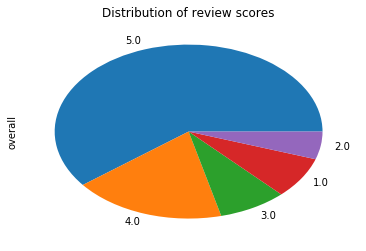

In [116]:
# Review score
joined.overall.value_counts().plot(kind='pie', title='Distribution of review scores')

We can see that more than half of the reviews gave five stars to the product. The low proportion of 1 and 2 star reviews suggests that customers are very likely to be satisfied with the product they purchased.

Let's now consider the number of reviews by month of the year.

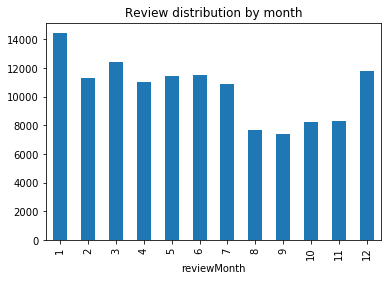

In [117]:
# joined.reviewMonth.value_counts().plot(kind='bar', title='Review distribution by month')
joined.groupby('reviewMonth').size().plot(kind = 'bar', title = 'Review distribution by month')

The number of reviews seems to be highest during winter and spring and lower during autumn, with January being the month with the highest number of reviews. We were surprised not to see December in the first place considering that winter holidays are traditionally a period of sales.

We can now start looking at the prices of the items. We can define some price bins that will allow us to group the items in price tiers.

In [118]:
# Arbitrarily chosen
price_bins = [
    0,
    10,
    20,
    30,
    40,
    50,
    60,
    70,
    80,
    90,
    100,
    200,
    500,
    1000
]

In [119]:
# Group the items by price tier
group_by_price_tier = joined.groupby(pd.cut(joined.price, price_bins))

First of all we can plot the distribution of the prices of reviewed items.

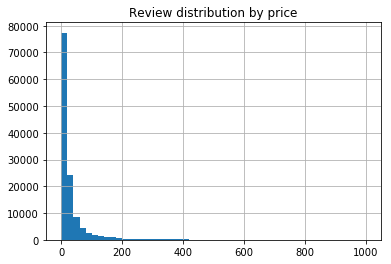

In [120]:
ax = plt.subplot()
joined.price.hist(bins=50, ax=ax)
ax.set_title('Review distribution by price')

The distribution seems to be heavy tailed, with very cheap items making up the majority of the reviews. We can verify if this distribution follows a power law by plotting it on a log-log scale.

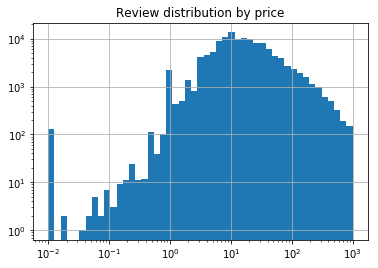

In [121]:
# We need to make logarithmic bins ourselves.
log_bins = np.logspace(np.log10(min(joined.price)), np.log10(max(joined.price)), 50)
ax = plt.subplot()
ax.set_title('Price')
joined.price.hist(ax=ax, log=True, bins=log_bins)
ax.set_xscale('log')
ax.set_title('Review distribution by price')

The distribution doesn't follow a linear relationship on a log-log plot so the distribution is not a power law.

Now let's see the distribution according to the price tiers we defined above.

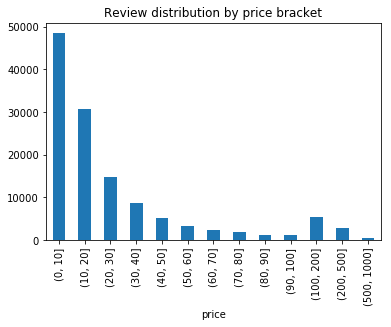

In [122]:
group_by_price_tier.asin.count().plot(kind='bar', title='Review distribution by price bracket')

One of the hypotheses we want to verify is whether the price of an item correlates with its review score, more specifically whether items belonging to a higher price tier are more likely to get better reviews. We can verify that by computing the mean review score for each price tier and displaying that on a bar plot.

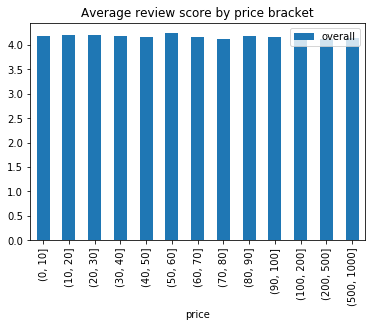

In [123]:
group_by_price_tier[['overall']].mean().plot(kind='bar', title='Average review score by price bracket')

There seems to be no correlation between an item's price tier and its mean review score.

We can also verify whether the month during which a review was written correlates with its score. The presence of such a correlation could indicate that buyers are more likely to give a better review in certain periods of the year than others.

In [124]:
# Group data by the month in which the review was written.
group_by_month = joined.groupby('reviewMonth')
average_month = group_by_month.overall

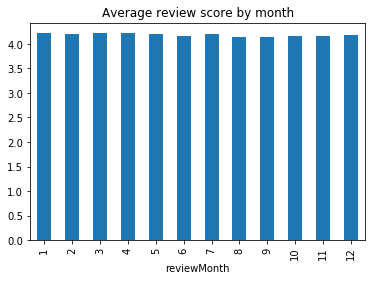

In [125]:
# Plot it
average_month.mean().plot(kind='bar', title='Average review score by month')

Again, we can see that the correlation we hypothesized does not exist in the data. The review scores seem to be independent of the month in which they were written.

We can now begin to group the items according to their category. Each item has a `categories` field which, when not absent, is an array of arrays of strings. Each item can belong to an arbitrary number of categories some of which are subcategories of a larger category. We will first flatten these arrays of arrays in order to make subsequent processing easier.

In [126]:
joined['categories_flat'] = joined.categories.apply(lambda a: [i for sa in a for i in sa])
joined = joined[[(c and bool(c[0])) for c in joined.categories_flat]]

In order to be able to plot aggregate values for each category we need to pick a list of categories that we will use as the main category of the product. One possible choice is the one that was used by the maintainer of the dataset to generate category-specific review files. Of course like in all real-world datasets the data is dirty and so not all products fit in at least one of these categories. Therefore we need to augment this list so that we cover as many items as possible and merge the ones we added into the original ones (for example `All beauty` should be merged with `Beauty`) later on.

In [127]:
# Taken from the dataset's page
main_categories = {
    'Books': 'Books',
    'Electronics': 'Electronics',
    'Movies & TV': 'Movies & TV',
    'CDs & Vinyl': 'Music',
    'Clothing, Shoes & Jewelry': 'Clothing, Shoes & Jewelry',
    'Home & Kitchen': 'Home & Kitchen',
    'Kindle Store': 'Kindle Store',
    'Sports & Outdoors': 'Sports & Outdoors',
    'Cell Phones & Accessories': 'Electronics',
    'Health & Personal Care': 'Health & Personal Care',
    'Toys & Games': 'Toys & Games',
    'Video Games': 'Video Games',
    'Tools & Home Improvement': 'Tools & Home Improvement',
    'Beauty': 'Beauty',
    'Apps for Android': 'Apps for Android',
    'Office Products': 'Office Products',
    'Pet Supplies': 'Pets',
    'Automotive': 'Automotive',
    'Grocery & Gourmet Food': 'Food',
    'Patio, Lawn & Garden': 'Patio, Lawn & Garden',
    'Baby': 'Baby',
    'Digital Music': 'Music',
    'Musical Instruments': 'Musical Instruments',
    'Amazon Instant Video': 'Amazon Instant Video',
    'Amazon Fashion': 'Clothing, Shoes & Jewelry',
    'Amazon Coins': 'Amazon Coins',
    'Software': 'Computing',
    'Baby Products': 'Baby',
    'Gift Cards': 'Gift Cards',
    'Arts, Crafts & Sewing': 'Arts, Crafts & Sewing',
    'Buy a Kindle': 'Kindle Store',
    'Appliances': 'Home & Kitchen',
    'MP3 Players & Accessories': 'Electronics',
    'Kitchen & Dining': 'Home & Kitchen',
    'All Beauty': 'Beauty',
    'Luxury Beauty': 'Beauty',
    'Computers': 'Computing',
    'Camera & Photo': 'Electronics',
    'Car Electronics': 'Automotive',
    'Gospel': 'Music',
    'Animal Care & Pets': 'Pets',
    'Jazz': 'Music',
    'GPS & Navigation': 'Electronics',
    'Office & School Supplies': 'Office Products',
    'Industrial & Scientific': 'Industrial & Scientific',
    'All Electronics': 'Electronics',
    'Home Improvement': 'Tools & Home Improvement',
    'Classical': 'Music',
    'Magazine Subscriptions': 'Magazine Subscriptions',
    'Alternative Rock': 'Music',
    'Gift Cards Store': 'Gift Cards',
    'Rock': 'Music',
    'Classic Rock': 'Music',
    'Christian': 'Music',
    'Pop': 'Music',
    'Folk': 'Music',
    'R&B': 'Music',
    'Soul': 'Music',
    'International': 'Music',
    'Electronica': 'Music',
    'Rap & Hip-Hop': 'Music',
    'Country': 'Music',
    'Comedy': 'Movies & TV', #??? 
    'New Age': 'Music',
    'Davis': 'Music', #???
    'Wine': 'Food',
    'Trading Cards': 'Toys & Games'
}

In [128]:
# Function that returns an item's main category according
# to the above list, or NaN if none of its categories appear in the list.
def get_main_category(categories):
    for c in categories:
        if c in main_categories:
            return main_categories[c]

    return np.nan

# Derive each product's main category
joined['main_category'] = joined.categories_flat.apply(lambda a: get_main_category(a))
joined = joined.dropna(axis=0, subset=['main_category'])

Plot the distribution of items by main category.

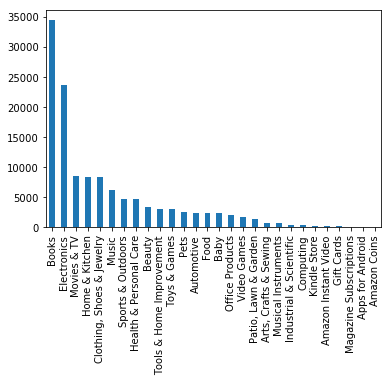

In [129]:
joined['main_category'].value_counts().plot(kind='bar')

The most popular categories by a large margin seem to be books and electronics.

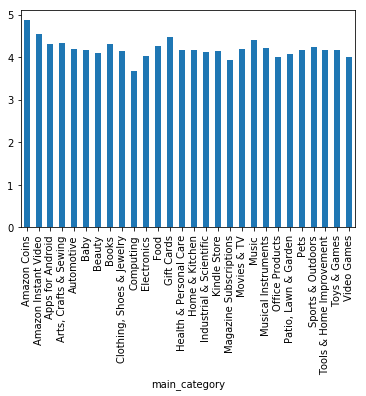

In [130]:
joined.groupby('main_category').overall.mean().plot(kind='bar')

In [131]:
# Create dataframe with needed information
product_reviews = pd.DataFrame({'productID': df.asin,
                                'rating': df.overall,
                                'time': pd.to_datetime(df.reviewTime, format='%m %d, %Y')
                                })
product_reviews['month'] = product_reviews.time.map(lambda t: t.month)
product_reviews.set_index('productID', drop=True, inplace=True)
product_reviews.head()

,rating,time,month
productID,,,
B005FYPK9C,5.0,2013-01-08,1
0871714779,1.0,2013-05-22,5
B00E7OIOVC,5.0,2014-07-03,7
B00EXOZ9W8,5.0,2014-07-02,7
B000G2OYOU,5.0,2012-11-20,11


In [132]:
# Create a product by month table to spot periodicity
# Each entry is the mean of ratings the product gets within certain month
# Nans are filled with 0
N_REVIEW_THRESHOLD = 20
product_month = product_reviews.pivot_table(values='rating',
                                            index=product_reviews.index,
                                            columns='month',
                                            fill_value=0)

# Select products with number of reviews larger than the threshold
review_count = product_reviews.index.value_counts()
product_month = product_month.loc[review_count>N_REVIEW_THRESHOLD]

product_month.head()

month,1,2,3,4,5,6,7,8,9,10,11,12
productID,,,,,,,,,,,,
006202406X,3.500000,3.000000,3.2,4.000000,0.0,3.333333,0.0,0.0,0.00,3.000000,3.750000,2.0
006228648X,3.000000,0.000000,1.0,2.333333,4.5,1.500000,0.0,0.0,0.00,2.500000,3.166667,3.0
030758836X,3.777778,4.000000,2.0,3.000000,3.0,3.666667,4.0,3.0,3.60,3.000000,3.800000,2.5
0307588378,4.666667,4.000000,5.0,0.000000,4.0,4.000000,1.0,5.0,4.25,2.666667,2.500000,3.0
038536315X,4.400000,4.666667,3.0,4.500000,5.0,0.000000,0.0,0.0,0.00,0.000000,3.500000,4.0


In [133]:
# Measure anolimity/eveness, higher is more even
def entropy(x):
    if (x==0).any():
        return 0
    nx = x/x.sum()
    return -(nx*np.log(nx)).sum()
def GMAM(x):
#     if (x==0).any():
#         return None
    return np.power(x.prod(), 1/len(x))/x.mean()

In [134]:
entropy(np.array([1]*5)), entropy(np.array([1,2,3,4,5])), entropy(np.array([1,1,1,1,5]))

(1.6094379124341005, 1.4897503188505912, 1.3030924037617191)

In [135]:
GMAM(np.array([1]*5)), GMAM(np.array([1,2,3,4,5])), GMAM(np.array([1,1,1,1,5]))

(1.0, 0.86839036156578409, 0.76651647858956384)

In [136]:
product_month['entropy'] = product_month.apply(entropy, axis=1)
product_month['GMAM'] = product_month.apply(GMAM, axis=1)
product_month.sort_values(by='entropy', inplace=True, ascending=False)
product_month.head(30)
# product_month.apply(entropy, axis=1).head(30)

month,1,2,3,4,5,6,7,8,9,10,11,12,entropy,GMAM
productID,,,,,,,,,,,,,,
B004LLILBY,4.866667,5.000000,5.000000,5.000000,5.000000,4.875000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,2.484860,0.985893
B00B7805QS,4.750000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000,2.483193,0.984865
B004KNWWQ8,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.500000,4.000000,5.000000,4.500000,4.500000,2.482607,0.985110
B007XZL7PC,5.000000,5.000000,5.000000,4.500000,4.500000,5.000000,5.000000,3.333333,4.000000,4.333333,4.000000,4.000000,2.477658,0.982702
B004KNWWPY,4.733333,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,5.000000,5.000000,5.000000,5.000000,2.477434,0.979228
B004LLILBO,4.500000,4.750000,4.833333,5.000000,2.500000,5.000000,5.000000,5.000000,4.666667,5.000000,5.000000,4.857143,2.472671,0.974645
030758836X,3.777778,4.000000,2.000000,3.000000,3.000000,3.666667,4.000000,3.000000,3.600000,3.000000,3.800000,2.500000,2.467094,0.979970
B001KXZ808,3.500000,5.000000,5.000000,5.000000,4.600000,4.500000,5.000000,1.000000,5.000000,5.000000,4.000000,5.000000,2.440884,0.930743
B005SUHR6C,4.666667,3.666667,5.000000,5.000000,5.000000,3.500000,5.000000,1.000000,4.500000,4.000000,3.000000,4.666667,2.436222,0.930961


In [137]:
# Audiobook, fifty shades of grey
meta_df.loc[meta_df.asin=='B007TNUULA'].iloc[0,:]

asin                                                  B007TNUULA
brand                                                        NaN
categories     [[Books, Literature & Fiction], [Books, Romanc...
description    Please note: This audiobook contains graphic a...
imUrl                                                        NaN
price                                                      23.95
related        {'also_bought': ['B007UWP5AG', 'B007UWPAD8', '...
salesRank                                                    NaN
title                                                        NaN
Name: 105986, dtype: object

In [139]:
# grey = product_reviews.loc['B007TNUULA'].sort_values(by='time')
# for index in range(grey.shape[0]):
#     row = grey.iloc[index]
#     print(row.iloc[[0,1,2,5,6]])
#     print(row.iloc[3])
#     print(row.iloc[4])

## ToDo: Spot/measure the periodicity (automatically)

In [140]:
# Distribution of rating per price bracket


### Sentiment and price bins:



In [141]:
print(joined.reviewYear.min())
print(joined.reviewYear.max())

1997
2014


In [142]:
# Label each review with price tier  
byprice = []
for tier in group_by_price_tier.groups.keys():
    by_tier = group_by_price_tier.get_group(tier)
    by_tier['priceInterval'] = tier
    
    byprice.append(by_tier)
    
    
    
label_byprice = pd.concat(byprice)

In [143]:
for tier in group_by_price_tier.groups.keys():
    pricetier = label_byprice[label_byprice['priceInterval'] == tier]
    print(tier, pricetier.groupby('overall').size()/pricetier.shape[0])

(0, 10] overall
1.0    0.072149
2.0    0.051514
3.0    0.087217
4.0    0.192451
5.0    0.596669
dtype: float64
(10, 20] overall
1.0    0.075698
2.0    0.051363
3.0    0.079104
4.0    0.180532
5.0    0.613303
dtype: float64
(20, 30] overall
1.0    0.078981
2.0    0.048858
3.0    0.082485
4.0    0.174944
5.0    0.614731
dtype: float64
(30, 40] overall
1.0    0.078179
2.0    0.052120
3.0    0.080727
4.0    0.178133
5.0    0.610841
dtype: float64
(40, 50] overall
1.0    0.083791
2.0    0.056711
3.0    0.080063
4.0    0.170330
5.0    0.609105
dtype: float64
(50, 60] overall
1.0    0.071495
2.0    0.046225
3.0    0.079199
4.0    0.175039
5.0    0.628043
dtype: float64
(60, 70] overall
1.0    0.082132
2.0    0.055483
3.0    0.082132
4.0    0.180865
5.0    0.599388
dtype: float64
(70, 80] overall
1.0    0.103014
2.0    0.050411
3.0    0.075068
4.0    0.174247
5.0    0.597260
dtype: float64
(80, 90] overall
1.0    0.085837
2.0    0.049785
3.0    0.068670
4.0    0.194850
5.0    0.600858
dtype: f

In [144]:
sentiment_byprice = label_byprice[['reviewText', 'priceInterval']]

In [145]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

train, test = train_test_split(sentiment_byprice, test_size=0.2, random_state = 1)

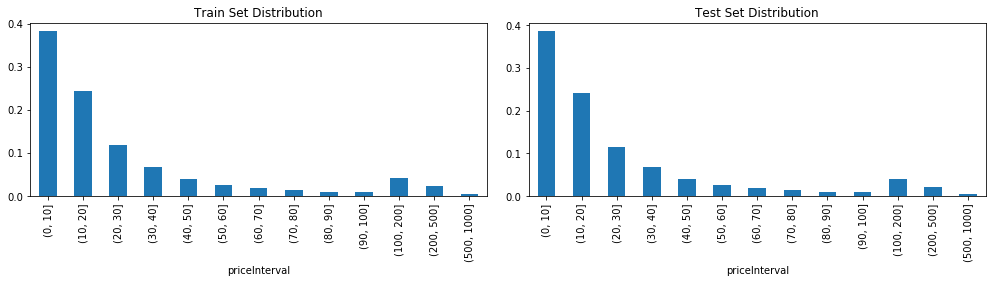

In [146]:
# Plot the distribution of documents among the categories for the train and test sets
fig, axs = plt.subplots(1,2, figsize = (14, 3))
plt.tight_layout()

# Training set distribution
axs[0].set_title('Train Set Distribution')
train_distr_norm = train.groupby('priceInterval').size()/train.shape[0]
train_distr_norm.plot(kind = 'bar', ax = axs[0])

# Test set distribution
axs[1].set_title('Test Set Distribution')
test_distr_norm = test.groupby('priceInterval').size()/test.shape[0]
test_distr_norm.plot(kind = 'bar', ax = axs[1])



In [147]:
print('train', train[train['priceInterval'] == pd.Interval(500,1000)].shape)
print('test', test[test['priceInterval'] == pd.Interval(500,1000)].shape)

train (457, 2)
test (122, 2)


AttributeError: 'DataFrame' object has no attribute 'Document'

In [186]:
joined.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,brand,categories,description,imUrl,price,related,salesRank,title,reviewMonth,reviewYear,categories_flat,main_category,sentiment_score,compound_score
0,B00E7OIOVC,"[0, 0]",5.0,Great!,2014-07-03,A0001528BGUBOEVR6T5U,igozingo,Five Stars,1404345600,niceEshop,"[[Home & Kitchen, Kitchen & Dining, Kitchen Ut...",Style flask funnel great to help you fill your...,http://ecx.images-amazon.com/images/I/31gMKQdA...,1.99,"{'also_bought': ['B004TQIB7U', 'B006O1EBHW', '...",{'Kitchen & Dining': 63021},niceEshop(TM) Small Stainless Steel Funnel For...,7,2014,"[Home & Kitchen, Kitchen & Dining, Kitchen Ute...",Home & Kitchen,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...",0.6588
1,B00EXOZ9W8,"[0, 0]",5.0,"My man was more then happy with it, looking fo...",2014-07-02,A00030342K9JCQO8Q7C3L,Joseph Dvorak,Five Stars,1404259200,NaN,"[[Home & Kitchen, Kitchen & Dining, Small Appl...",,http://ecx.images-amazon.com/images/I/41Oc0HaP...,65.81,"{'also_bought': ['B000FAJ0K6', 'B0012UY6XO', '...",{'Kitchen & Dining': 56153},BELLA 14025 Programmable Slow Cooker with Lock...,7,2014,"[Home & Kitchen, Kitchen & Dining, Small Appli...",Home & Kitchen,"{'neg': 0.0, 'neu': 0.651, 'pos': 0.349, 'comp...",0.7893
2,1477473939,"[0, 0]",4.0,Reading this seriers was a amazing. It was ver...,2013-01-26,A000443821AD43TOGKNGZ,Uluwehi,Really enjoyed it!,1359158400,NaN,[[Books]],USA Today Best Selling Author Elizabeth Reyes...,http://ecx.images-amazon.com/images/I/51bhuPCO...,4.99,"{'also_bought': ['147522186X', '1475244207', '...",{'Books': 1011147},Making You Mine: The Moreno Brothers,1,2013,[Books],Books,"{'neg': 0.0, 'neu': 0.647, 'pos': 0.353, 'comp...",0.9199
3,1477473939,"[0, 0]",4.0,"I haven't read any of this series before, but ...",2013-04-09,A1BAWRQQMC7L72,Roswellfan410,Really liked it,1365465600,NaN,[[Books]],USA Today Best Selling Author Elizabeth Reyes...,http://ecx.images-amazon.com/images/I/51bhuPCO...,4.99,"{'also_bought': ['147522186X', '1475244207', '...",{'Books': 1011147},Making You Mine: The Moreno Brothers,4,2013,[Books],Books,"{'neg': 0.0, 'neu': 0.589, 'pos': 0.411, 'comp...",0.9548
4,B0092QSQ3Q,"[0, 0]",5.0,It is really good! But it was hard to push out...,2012-11-03,A00044782UB564I4SGA0X,Johan98,Really good!,1351900800,NaN,"[[Cell Phones & Accessories, Accessories, Scre...",Protect your InvestmentDaily use of your mobil...,http://ecx.images-amazon.com/images/I/51722Hcw...,5.95,"{'also_bought': ['B00FDXLRM4', 'B009VO0506', '...",{'Cell Phones & Accessories': 4377},Skinomi&reg; TechSkin - Apple iPhone 5 Screen ...,11,2012,"[Cell Phones & Accessories, Accessories, Scree...",Electronics,"{'neg': 0.056, 'neu': 0.716, 'pos': 0.228, 'co...",0.6534


In [150]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

In [152]:
vs = analyzer.polarity_scores(joined.loc[2]['reviewText'])

In [153]:
vs

{'compound': 0.6588, 'neg': 0.0, 'neu': 0.0, 'pos': 1.0}

In [180]:
joined.reset_index(drop = True, inplace = True)

In [171]:
scores = []
compound_score = []
for index in joined.index:
    polarity = analyzer.polarity_scores(joined.loc[index, 'reviewText'])
    scores.append(polarity)
    compound_score.append(polarity['compound'])
    
joined.loc[:,'sentiment_score'] = pd.Series(scores)
joined.loc[:, 'compound_score'] = pd.Series(compound_score)

In [181]:
joined.loc[:,'sentiment_score'] = pd.Series(scores)
joined.loc[:, 'compound_score'] = pd.Series(compound_score)

In [182]:
# group by price bins and
joined.groupby(pd.cut(joined.price, price_bins))['compound_score'].mean()

price
(0, 10]        0.580950
(10, 20]       0.587760
(20, 30]       0.591260
(30, 40]       0.586828
(40, 50]       0.587216
(50, 60]       0.593859
(60, 70]       0.592124
(70, 80]       0.580924
(80, 90]       0.575644
(90, 100]      0.605817
(100, 200]     0.575762
(200, 500]     0.608923
(500, 1000]    0.597688
Name: compound_score, dtype: float64

In [231]:
# Look at each category, sentiment score per rating
def plot_each_category(groupby, column_to_average):
    categories = joined.main_category.unique()
    for c in categories:
        x = joined[joined['main_category'] == c]
        print(c)
        if groupby is 'price':
            (x.groupby(pd.cut(x.price, price_bins))[column_to_average].mean()).plot(kind = 'bar')
        else:
            (x.groupby(groupby)[column_to_average].mean()).plot(kind = 'bar')
        plt.show()

Home & Kitchen


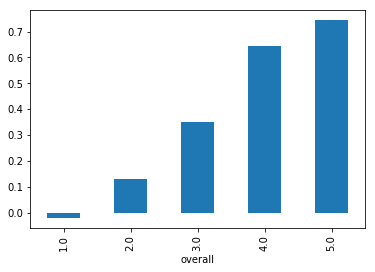

Books


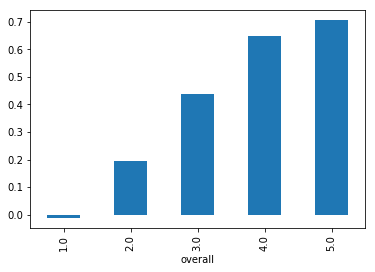

Electronics


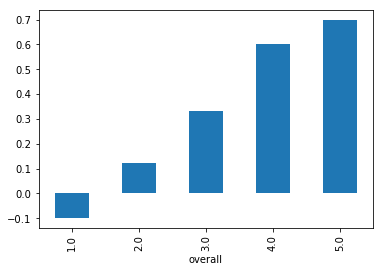

Food


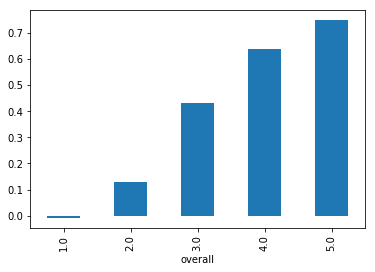

Health & Personal Care


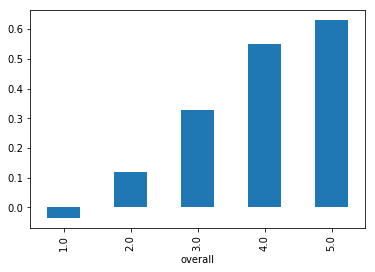

Movies & TV


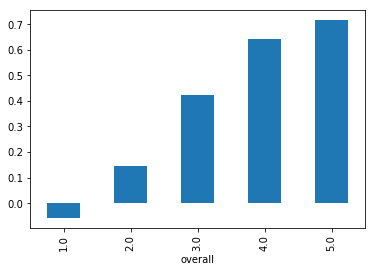

Office Products


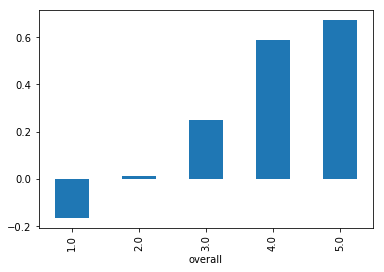

Music


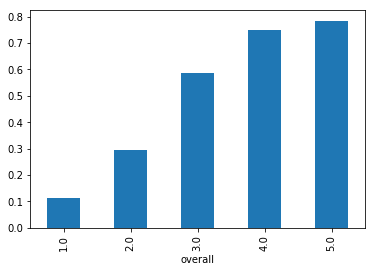

Video Games


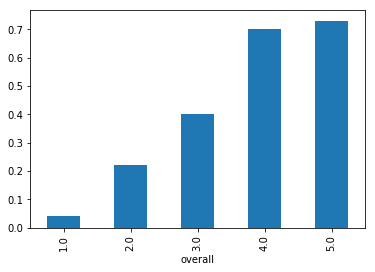

Clothing, Shoes & Jewelry


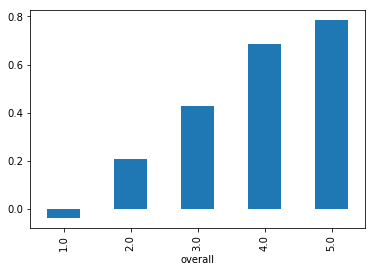

Beauty


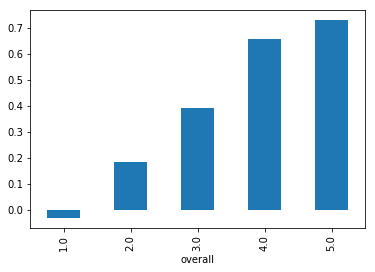

Musical Instruments


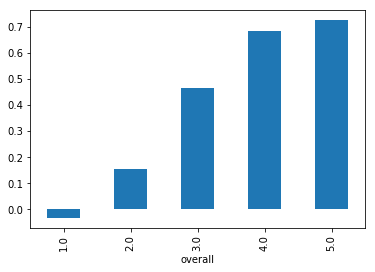

Tools & Home Improvement


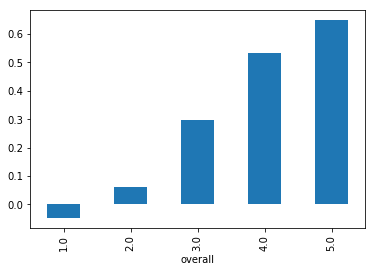

Automotive


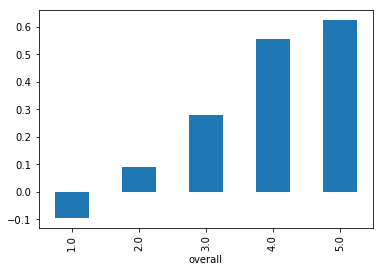

Gift Cards


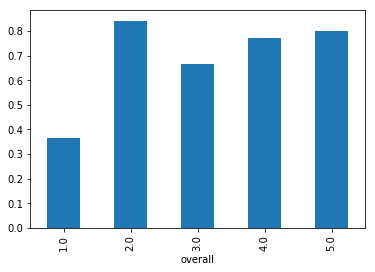

Patio, Lawn & Garden


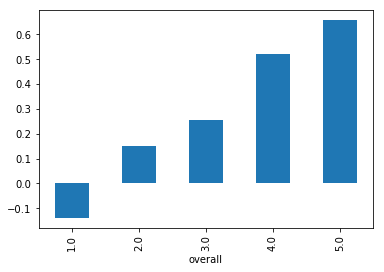

Arts, Crafts & Sewing


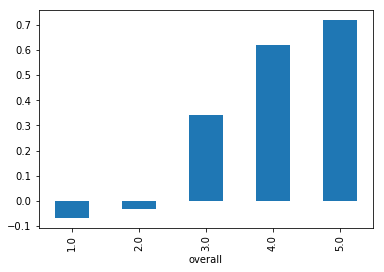

Sports & Outdoors


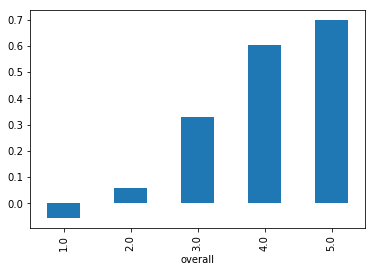

Amazon Coins


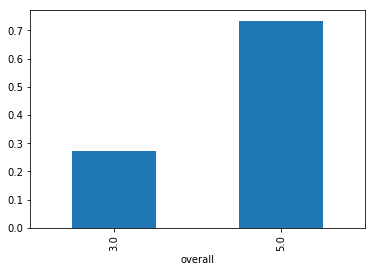

Toys & Games


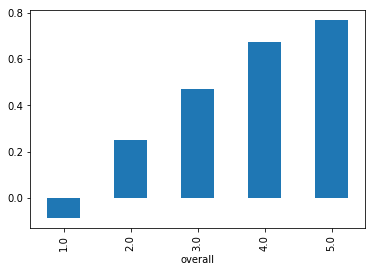

Baby


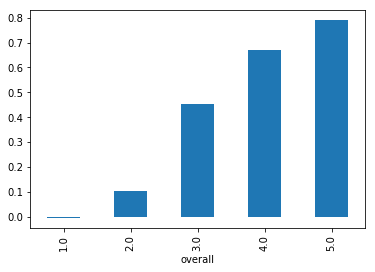

Pets


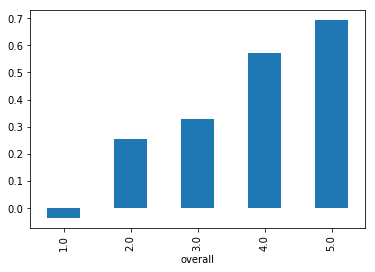

Amazon Instant Video


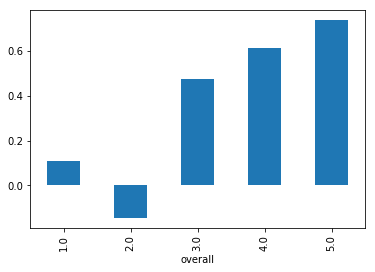

Industrial & Scientific


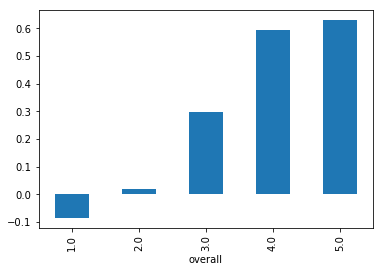

Apps for Android


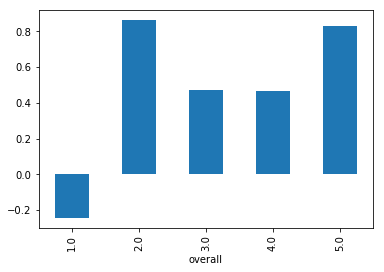

Kindle Store


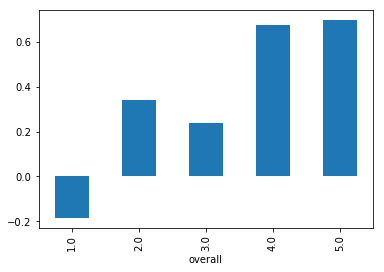

Computing


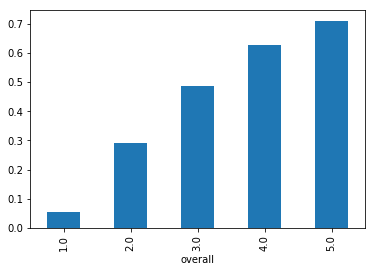

Magazine Subscriptions


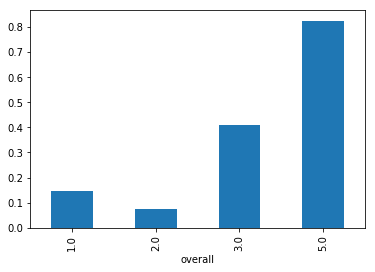

In [226]:
plot_each_category('overall', 'compound_score')

Home & Kitchen


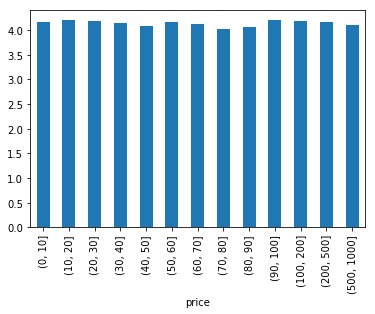

Books


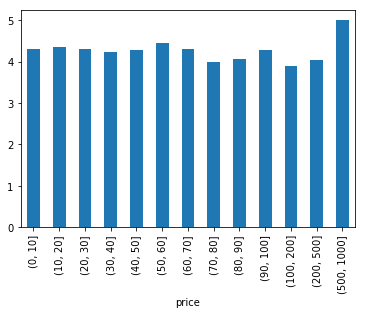

Electronics


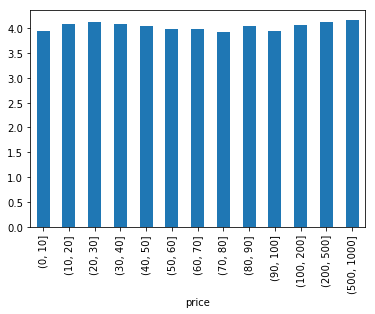

Food


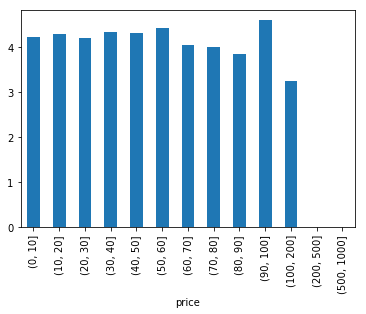

Health & Personal Care


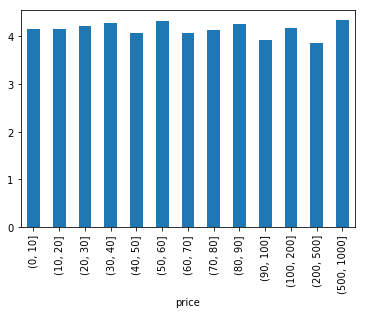

Movies & TV


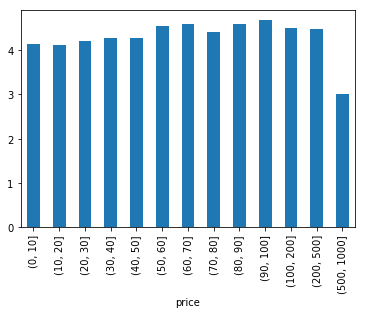

Office Products


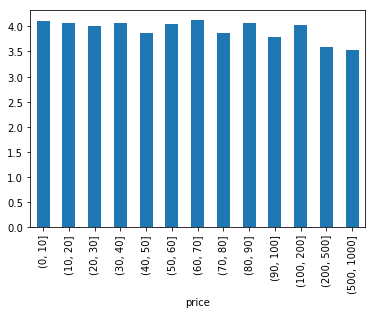

Music


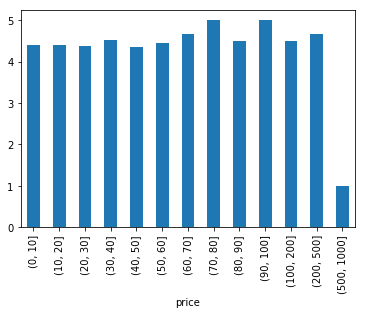

Video Games


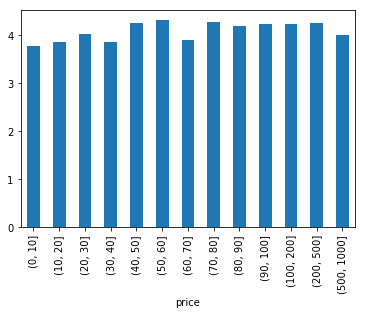

Clothing, Shoes & Jewelry


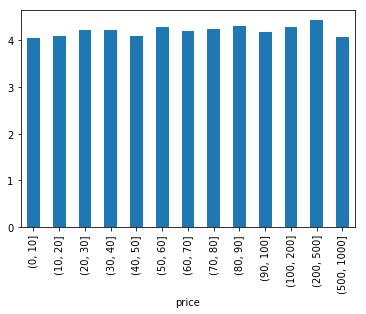

Beauty


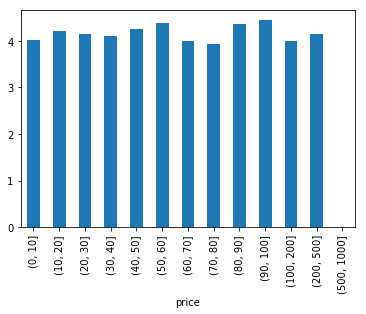

Musical Instruments


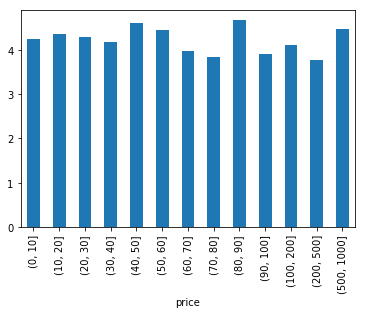

Tools & Home Improvement


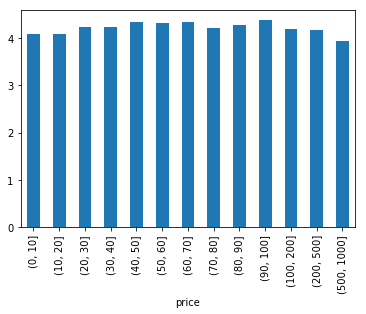

Automotive


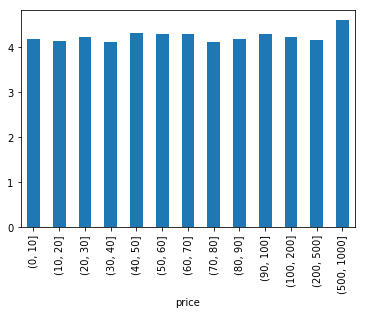

Gift Cards


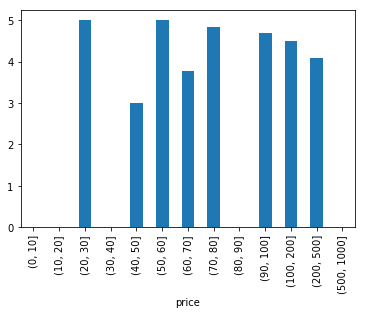

Patio, Lawn & Garden


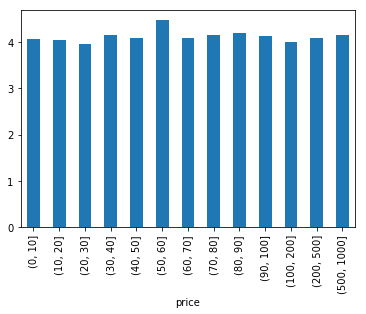

Arts, Crafts & Sewing


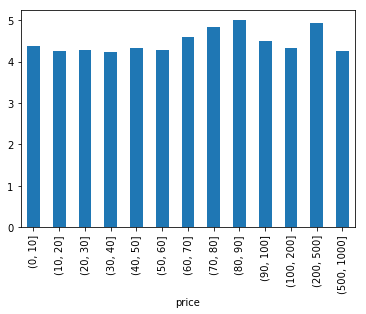

Sports & Outdoors


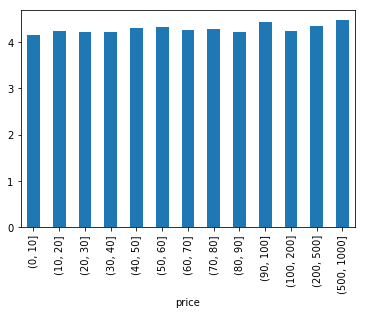

Amazon Coins


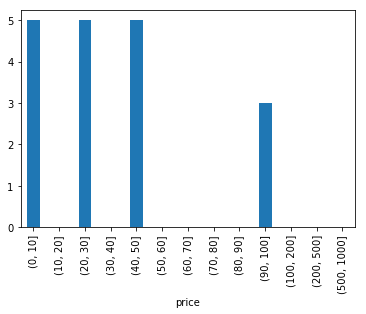

Toys & Games


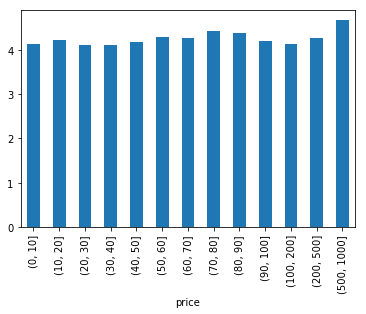

Baby


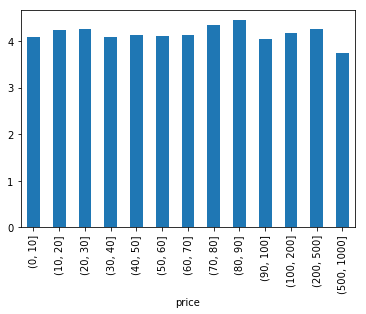

Pets


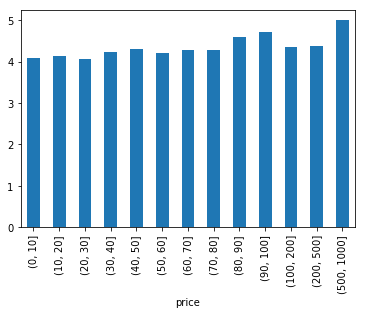

Amazon Instant Video


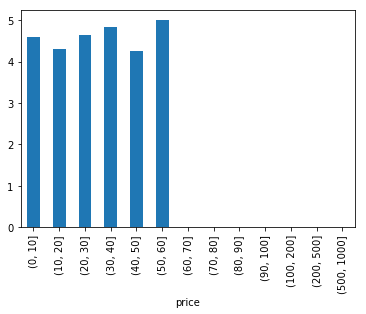

Industrial & Scientific


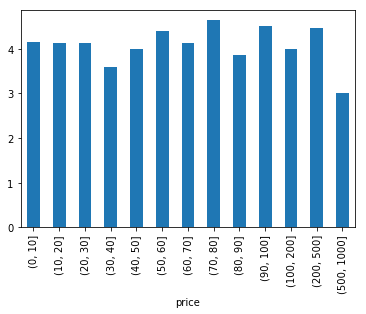

Apps for Android


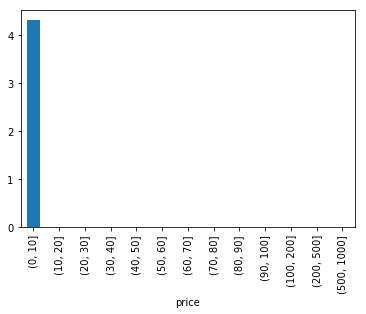

Kindle Store


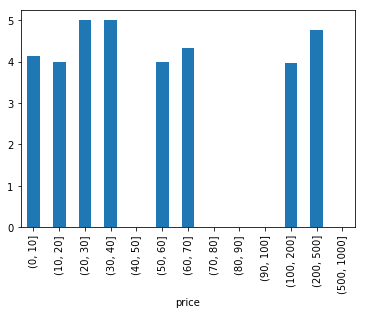

Computing


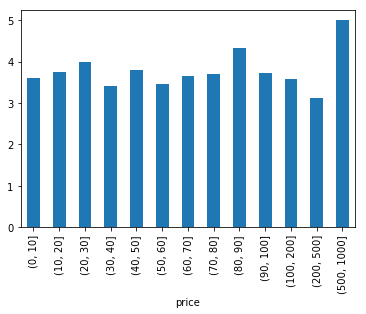

Magazine Subscriptions


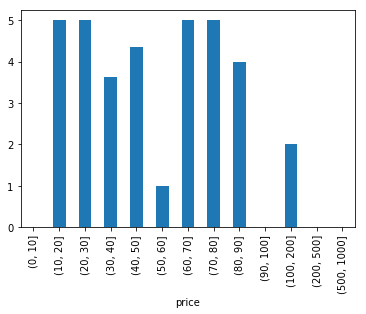

In [232]:
# Look at each category, rating per price bin
plot_each_category('price', 'overall')

Home & Kitchen


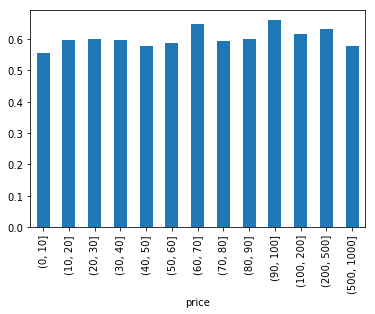

Books


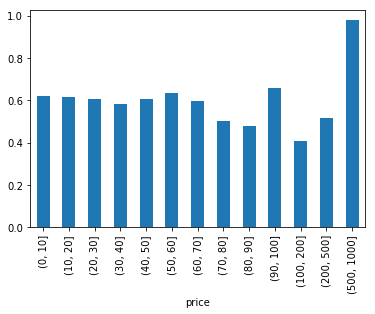

Electronics


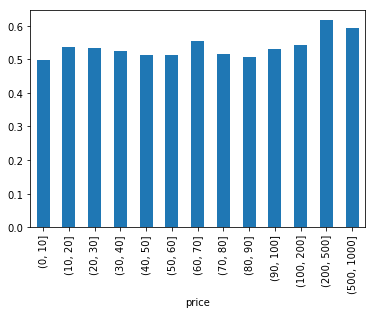

Food


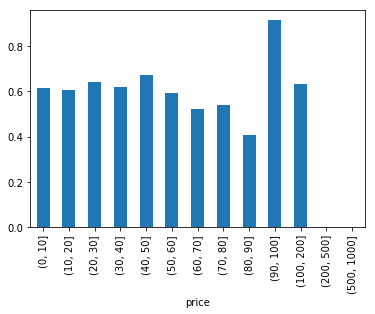

Health & Personal Care


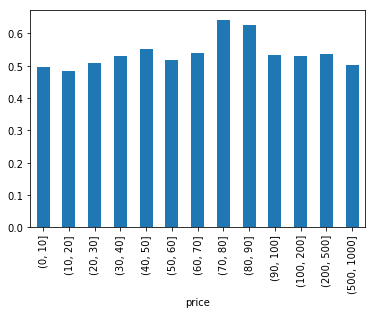

Movies & TV


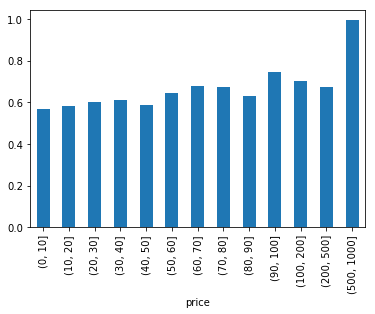

Office Products


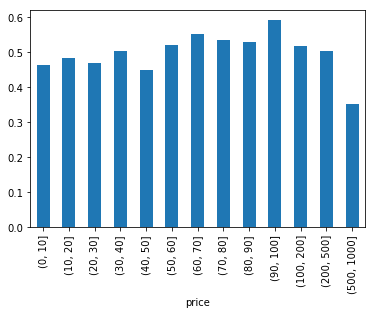

Music


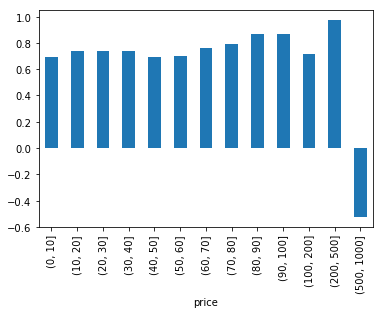

Video Games


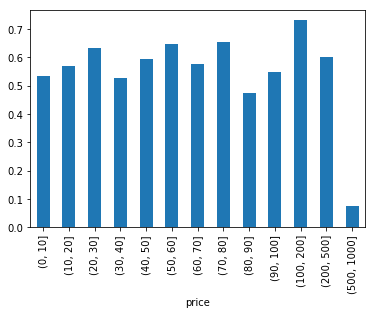

Clothing, Shoes & Jewelry


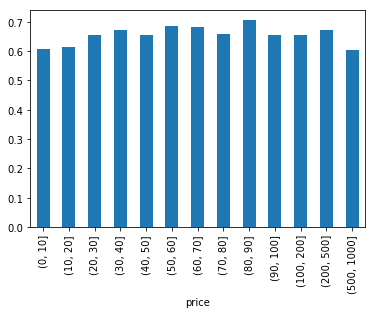

Beauty


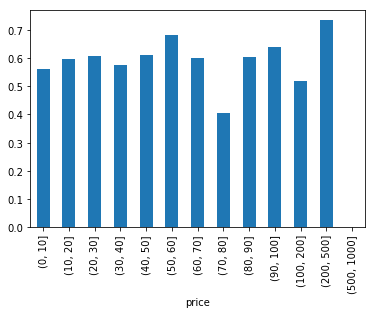

Musical Instruments


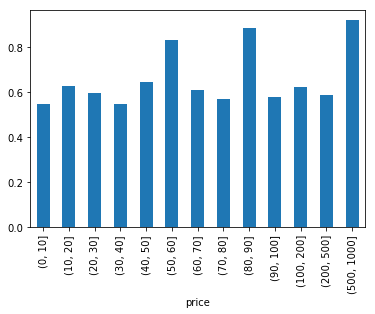

Tools & Home Improvement


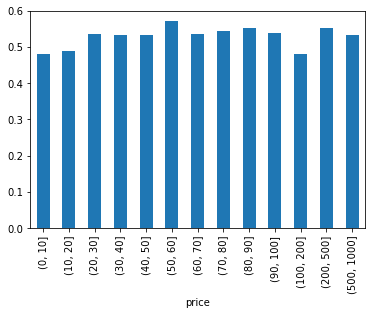

Automotive


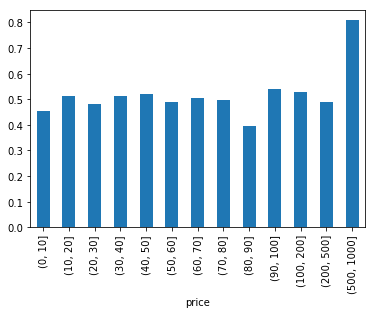

Gift Cards


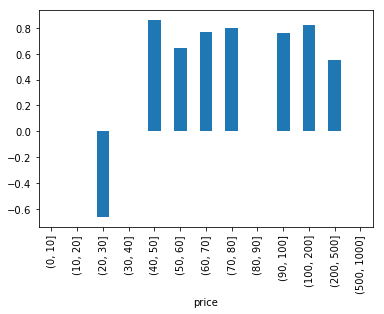

Patio, Lawn & Garden


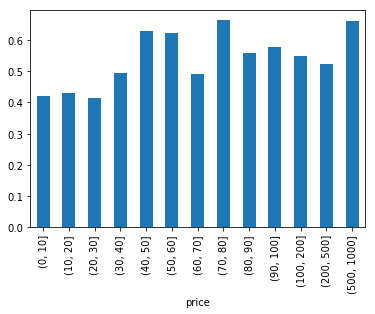

Arts, Crafts & Sewing


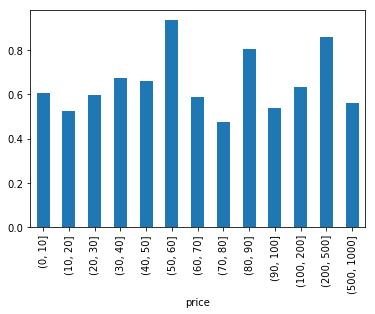

Sports & Outdoors


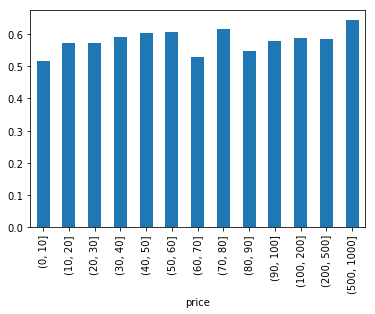

Amazon Coins


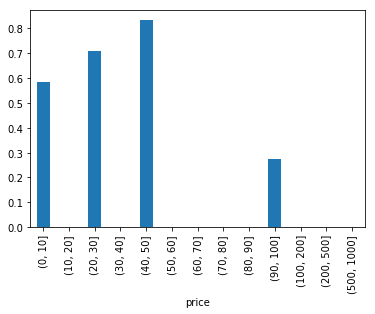

Toys & Games


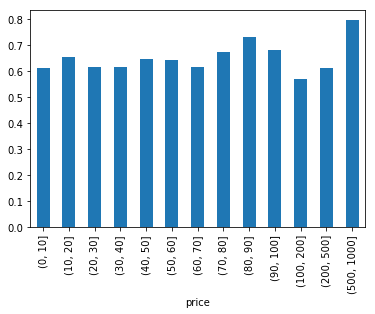

Baby


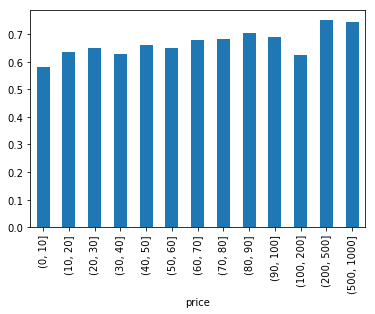

Pets


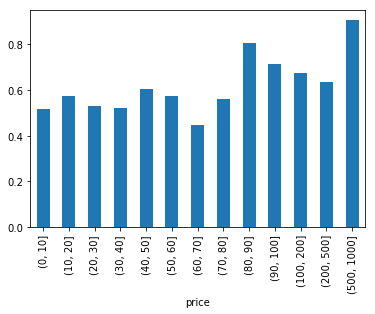

Amazon Instant Video


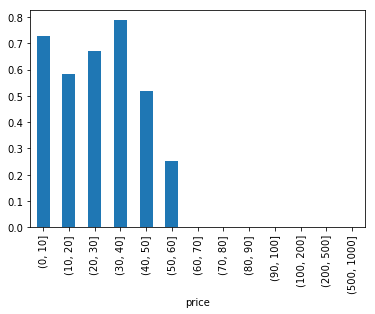

Industrial & Scientific


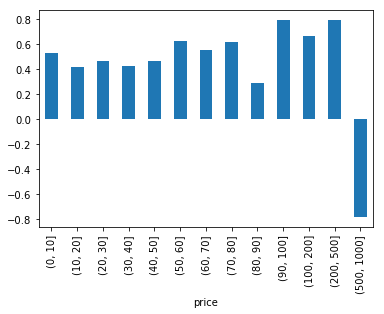

Apps for Android


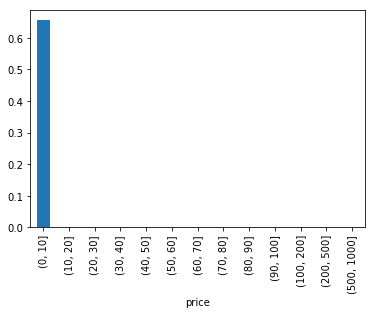

Kindle Store


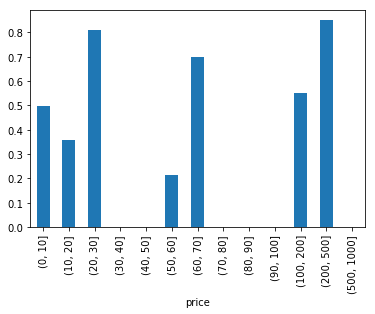

Computing


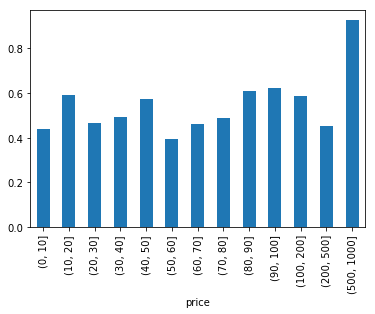

Magazine Subscriptions


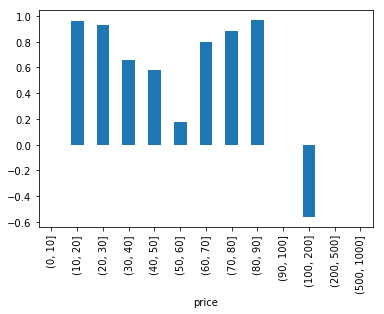

In [233]:
# Look at each category, sentiment score per price bin
plot_each_category('price', 'compound_score')

Home & Kitchen


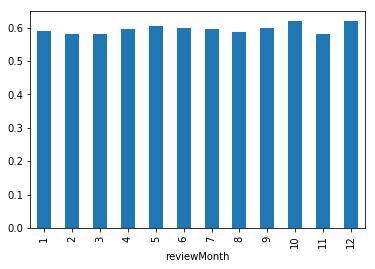

Books


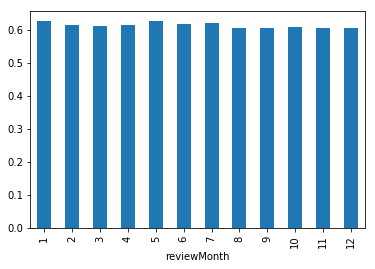

Electronics


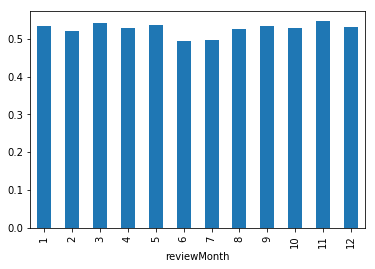

Food


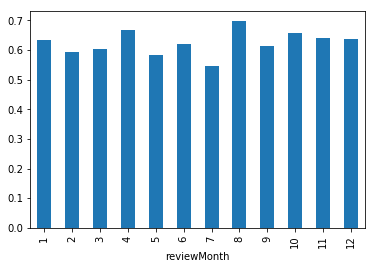

Health & Personal Care


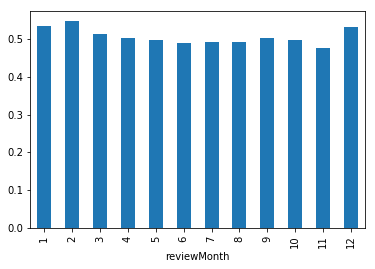

Movies & TV


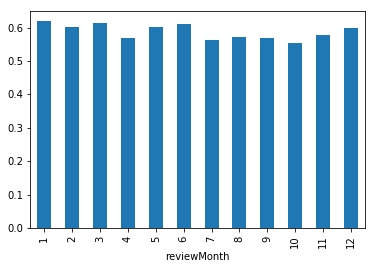

Office Products


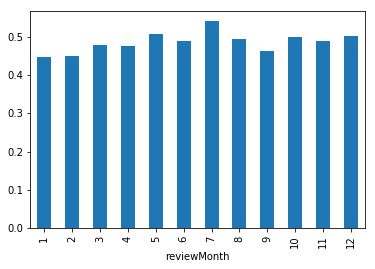

Music


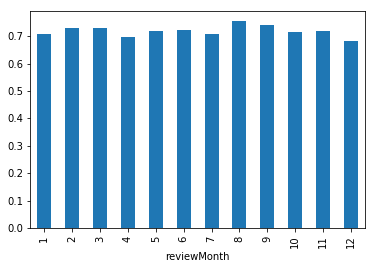

Video Games


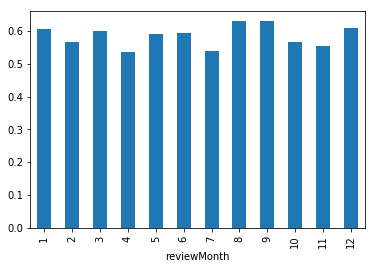

Clothing, Shoes & Jewelry


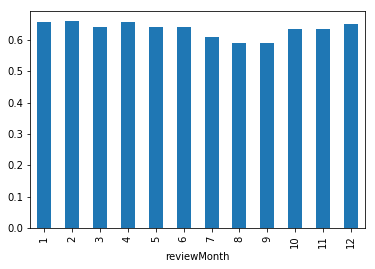

Beauty


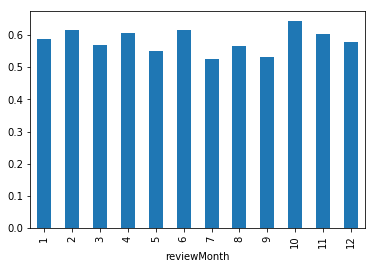

Musical Instruments


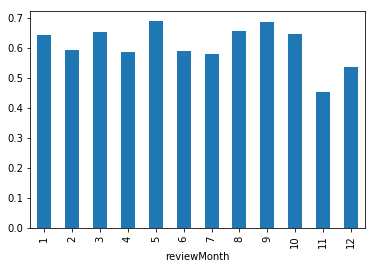

Tools & Home Improvement


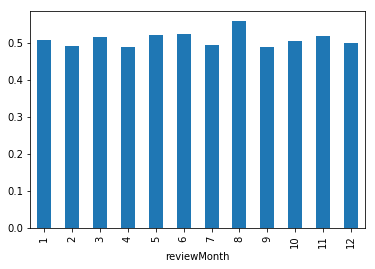

Automotive


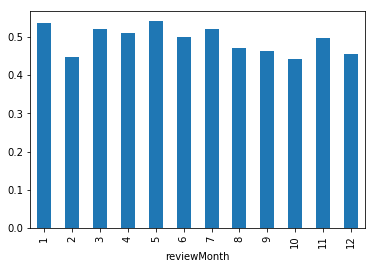

Gift Cards


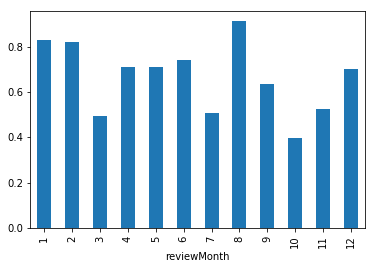

Patio, Lawn & Garden


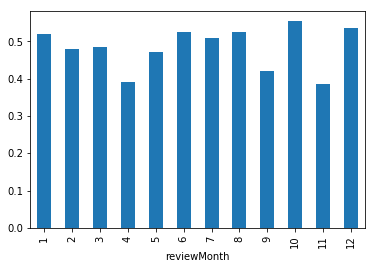

Arts, Crafts & Sewing


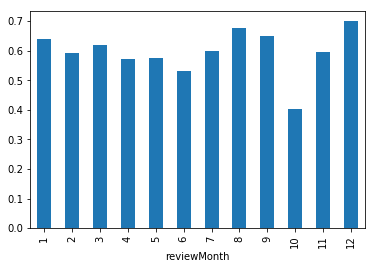

Sports & Outdoors


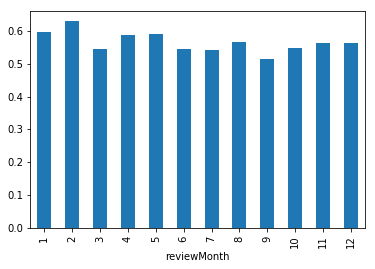

Amazon Coins


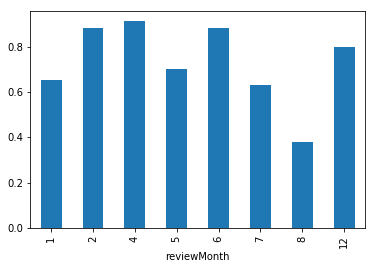

Toys & Games


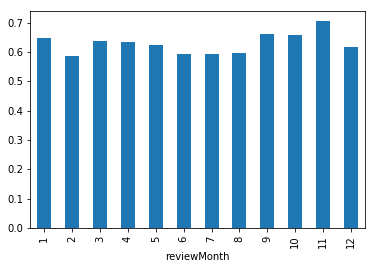

Baby


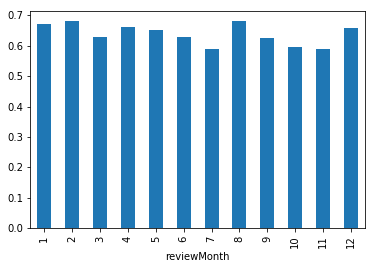

Pets


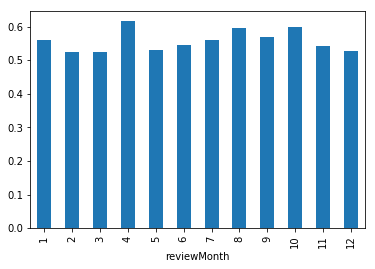

Amazon Instant Video


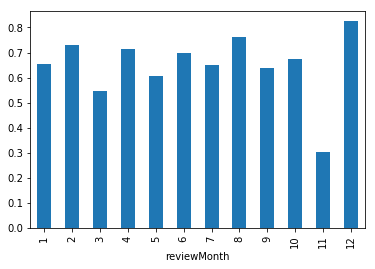

Industrial & Scientific


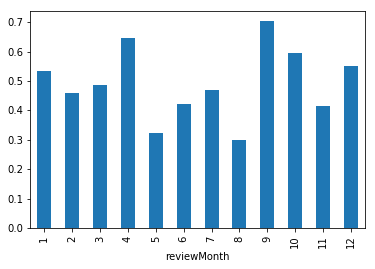

Apps for Android


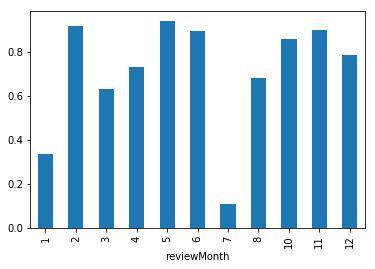

Kindle Store


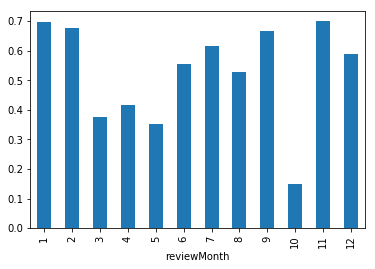

Computing


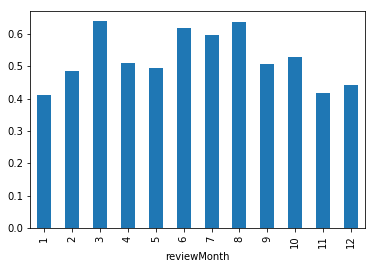

Magazine Subscriptions


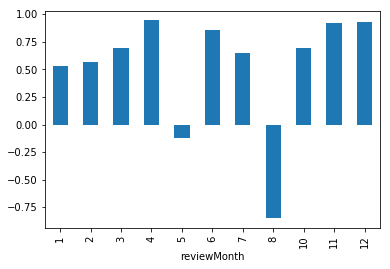

In [228]:
# Look at each category, sentiment score per month
plot_each_category('reviewMonth', 'compound_score')


Home & Kitchen


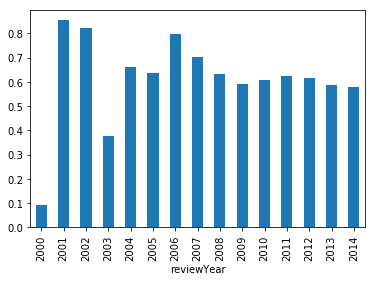

Books


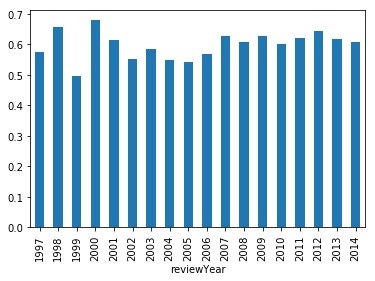

Electronics


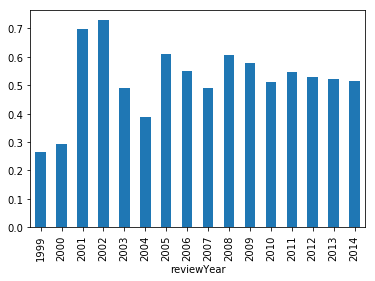

Food


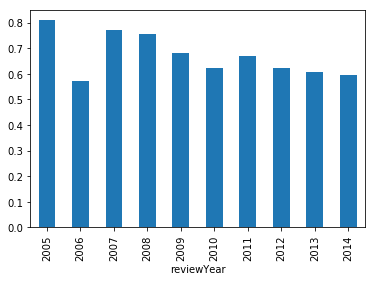

Health & Personal Care


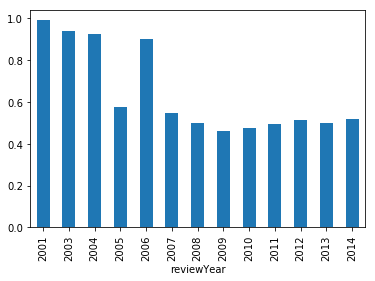

Movies & TV


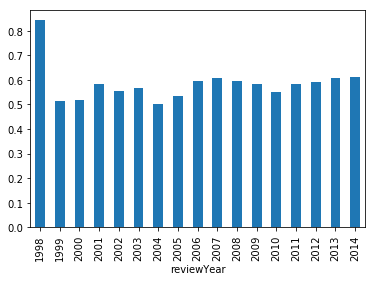

Office Products


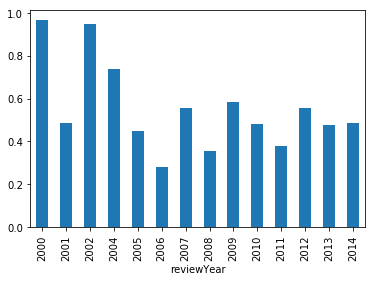

Music


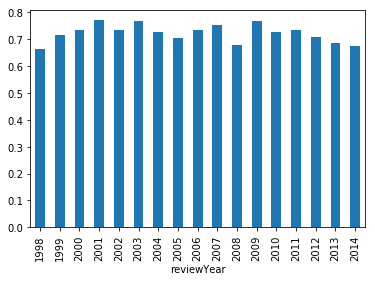

Video Games


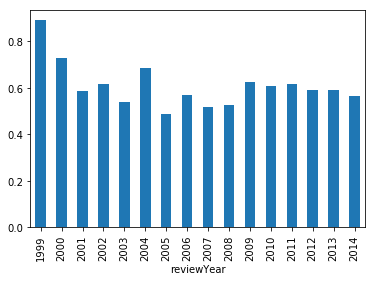

Clothing, Shoes & Jewelry


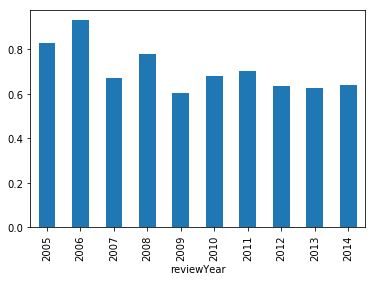

Beauty


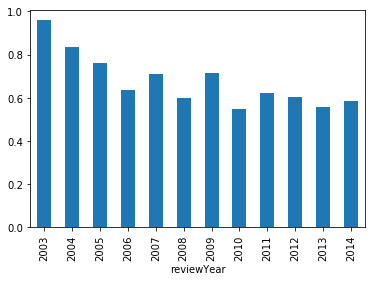

Musical Instruments


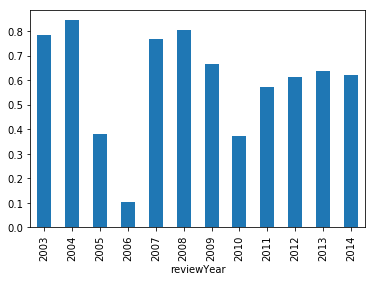

Tools & Home Improvement


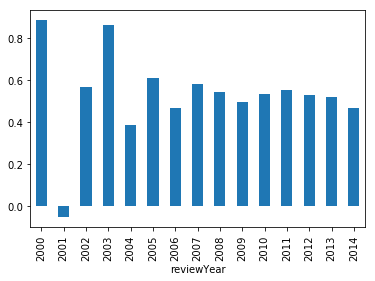

Automotive


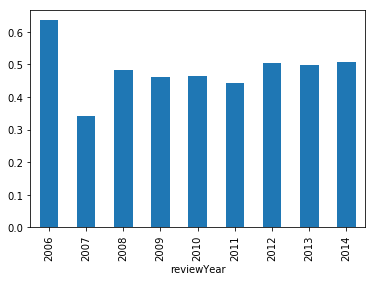

Gift Cards


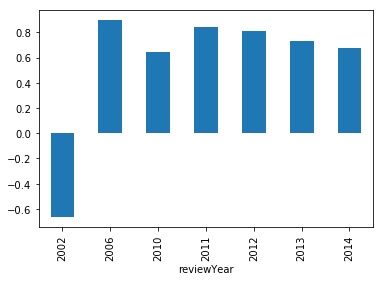

Patio, Lawn & Garden


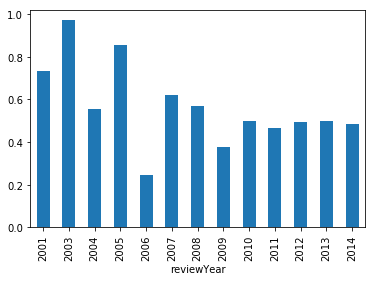

Arts, Crafts & Sewing


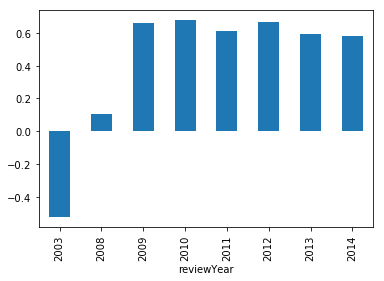

Sports & Outdoors


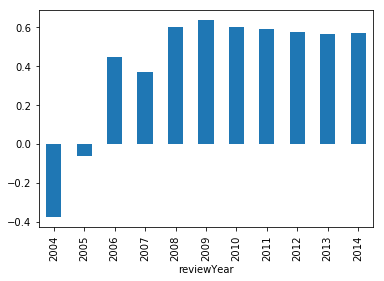

Amazon Coins


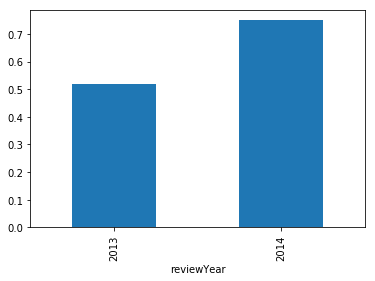

Toys & Games


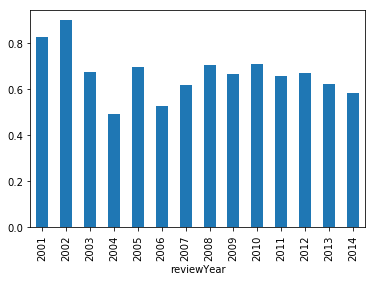

Baby


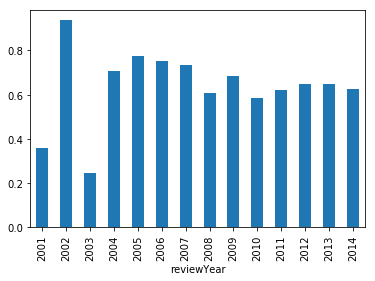

Pets


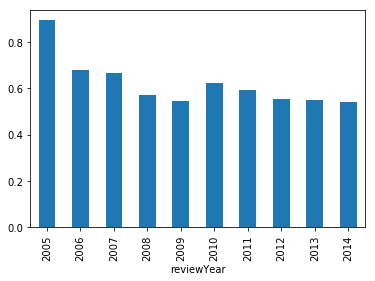

Amazon Instant Video


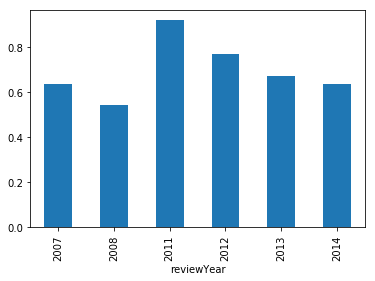

Industrial & Scientific


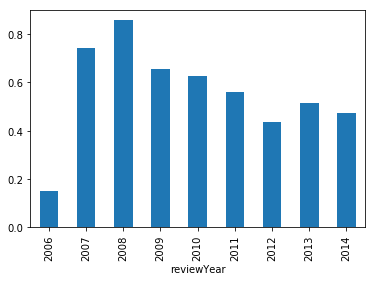

Apps for Android


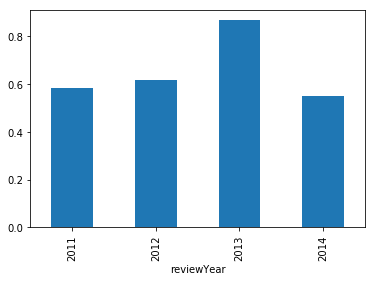

Kindle Store


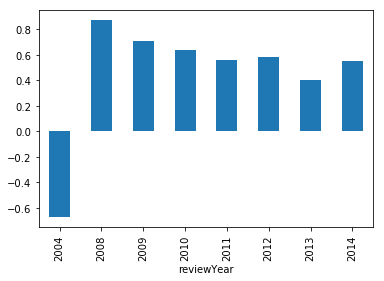

Computing


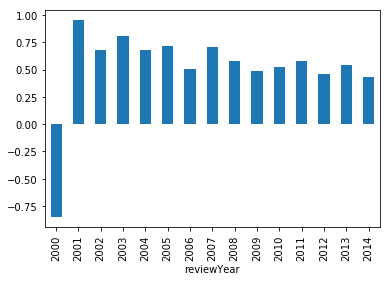

Magazine Subscriptions


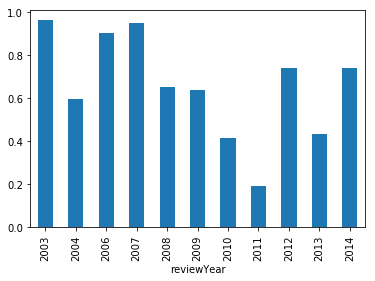

In [229]:
# Look at each category, sentiment score per month
plot_each_category('reviewYear', 'compound_score')

### do something with respect to salesrank

In [209]:
joined.groupby('asin').price.max()

asin
0002007770      8.52
0002008572     14.37
0002172747      2.99
000224053X      5.22
0002242052      6.60
0002247399      4.99
0004126483     17.04
0004724526     18.27
0005119367      6.88
000615591X      8.99
0006165699      9.99
0006281052      8.96
0006514006      8.99
0006530702      8.89
0006550436      6.83
0006551386     10.99
0006551807      8.52
0006641288     13.35
0007101112      5.69
0007111509      6.64
0007118899      9.99
0007124015      9.99
0007133103     14.68
0007136838      3.99
0007141785      9.39
0007149832     10.23
0007157150     10.45
0007157177      7.59
0007161263      9.78
0007167040      8.59
               ...  
B00LATJ2F4     99.99
B00LBI9BKA    119.95
B00LBLN1EY      4.99
B00LBQZPZC      9.99
B00LC9PSI2    119.99
B00LCG5S4O     19.99
B00LCIMVHY      0.99
B00LD8IMWQ      2.99
B00LDTZAD4      2.99
B00LDV3WUK      0.99
B00LDW4DAW      3.95
B00LER2VVE      7.13
B00LEZTE7A      2.99
B00LF2PGME      2.99
B00LF5789U      3.99
B00LF9I7CI      2.99
B00LFE9U